In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
import random
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from astropy.timeseries import LombScargle
from numpy import linalg

A method to generate a series of times (in days) that would reflect realistic sample times from the Vera Rubin observatory given a duration of the gap in terms of days and a duration in terms of years

In [33]:
def generate_spaced_times(space_duration, total_days):
    # Generate a list of times that are approximately the given days apart
    times_clean = np.linspace(0, total_days, int(total_days / space_duration))
    variability = np.random.normal(0, 1, len(times_clean) - 1)
    variability = np.insert(variability, 0, 0)
    times = np.add(times_clean, variability)
    
    return times


def generate_gap(times, gap_duration):
    # Generate a random location each year at which the gap will take place
    gap_beginning = random.randint(0, 365)
    gap_end = gap_beginning + gap_duration
    
    # Generate a list that will be the values that each gap begins and then ends
    intervals = [[gap_beginning, gap_end]]
    while intervals[len(intervals) - 1][0] + 365 < np.max(times):
        intervals.append([intervals[len(intervals) - 1][0] + 365, intervals[len(intervals) - 1][1] + 365])
        
    for interval in intervals:
        times = [time for time in times if (interval[0] >= time <= interval[1]) or (interval[0] <= time >= interval[1])]
    
    return times


def generate_Vera_Rubin_times(gap_duration, total_duration, spacing = 3):
    total_days = total_duration * 365 # The amount of days the light curve will be
    
    # Generate a list of times that are approximately 3 days apart
    times = generate_spaced_times(spacing, total_days)
    
    # Delete the values in a random location of the times for a given gap
    times_gapped = generate_gap(times, gap_duration)
    times_gapped = sorted(times_gapped, key = lambda x:float(x)) 
    
    return times_gapped

def generate_periodic_LC(t_rest, amplitude, nu, phi):
    # Create a list of points 0-2pi that will correspond to each values in t_rest
    t = (np.array(t_rest) / max(t_rest)) * 2 * np.pi
  
    # Create a light curve
    F = amplitude * np.sin(nu * t + phi)
  
    return F

def generate_periodic_DRW_LC(t_rest, sigma, tau, z, amplitude, nu, phi):
    # Generate the two components
    noise = np.array(generate_DRW_LC(t_rest, sigma, tau, z))
    periodicity = np.array(generate_periodic_LC(t_rest, amplitude, nu, phi))

    # Combine them
    lc = noise + periodicity
  
    return lc

def generate_DRW_LC(t_rest, sigma, tau, z):
    # Account for redshift:
    t_obs = []

    # Account for redshift
    tau_rf = tau / (1 + z)

    # Make first value of the light curve and declare a light curve list
    lc1 = np.random.normal(0, sigma, None)
    lc = [lc1]

    # Fill the lightcurve list
    for i in range(1, len(t_rest)):
        dt = t_rest[i] - t_rest[i - 1]
        lc_next = lc[i - 1] * np.exp(-dt / tau_rf) + np.random.normal(0, (sigma) * (1 - np.exp((-2 * dt) / tau_rf)), None)
        lc.append(lc_next)

    return lc

def fit_DRW(t_rest, lc, z, steps, sigma_range = [.1, 10], tau_range = [1, 100]):
    # Create variables that will be used to maximize likelihood
    sigmas = np.array([sigma_range[0] + (s / steps) * (sigma_range[1] - sigma_range[0]) for s in range(steps + 1)])
    taus = np.array([tau_range[0] + (t / steps) * (tau_range[1] - tau_range[0]) for t in range(steps + 1)])
    loglikelihoods = np.zeros((len(sigmas), len(taus)))
    delta_t_matrix = np.zeros((len(t_rest), len(t_rest)))
    for i in range(len(t_rest)):
        for j in range(len(t_rest)):
            delta_t_matrix[i][j] = abs(t_rest[i] - t_rest[j])
    
    # Find the likelihood of all sigmas and taus and then return the one that affords the greatest likelihood
    for s in range(len(sigmas)):
        for t in range(len(taus)):
            loglikelihoods[s][t] = get_loglikelihood(delta_t_matrix, lc, sigmas[s], taus[t], 0)
    cords = np.where(loglikelihoods == np.amax(loglikelihoods))
    fits = sigmas[cords[0][0]], taus[cords[1][0]]

    return fits

def prior_transform(u):
    # these are priors in log10 units (based on uniform random deviate from 0 to 1) except for phase
    v = u * 100
    v[0] = (u[0]-0.5) * 4 - 0.6
    v[1] = (u[1]-0.5) * 4
    v[2] = (u[2] % 1.) * 1 * np.pi
    v[3] = (u[3]-0.5) * 2 - 0.3
    v[4] = (u[4]-0.5) * 2 + 1.0
    return v

def loglike(v):
    # Get loglikelihood for the periodic portion
    logna, logfa, pa, logsigma, logtau = v   # non-periodic parameters are passed as log10(param)
    na, fa, pa, sigma, tau = (10**logna, 10**logfa, pa, 10**logsigma, 10**logtau)
    ypred = np.array(generate_periodic_LC(times_VR, na, fa, pa))
    residsq = (ypred  - periodic_drw)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    # Subtract periodic estimations and fit the residual drw
    resid_drw = periodic_drw - ypred
    
    # Calculate the drw likelihood for the residual drw
    drw_loglikelihood = get_loglikelihood(delta_t_matrix, resid_drw, sigma, tau, 0)
    
    if not np.isfinite(loglike):
        loglike = -1e300
        
    return loglike + drw_loglikelihood

def get_loglikelihood(delta_t_matrix, lc, sigma, tau, z):
    S = generate_cov_matrix(delta_t_matrix, sigma, tau) # Cov matrix of the lc
    C_inv = linalg.inv(S) # Inverse of C (C = S + N) N is cov matrix of noise
    L = np.zeros((len(lc), 1)) + 0.5 # Matrix of 0.5s
    L_trans = np.transpose(L) # L transposed
    y = np.zeros((len(lc), 1)) # Matrix of given light curve
    y[:,0] = lc
    y_trans = np.transpose(y) # y transposed
    C_inv_up1 = C_inv 
    denom = np.matmul(np.matmul(L_trans, C_inv), L) # Denominator of likelihood equation
    A = np.matmul(L_trans, C_inv)
    B = np.matmul(C_inv,L)
    C_inv_uptack = C_inv_up1 - np.matmul(B,A) / denom
    expval = -0.5 * (np.matmul(np.matmul(y_trans, C_inv_uptack), y))
    loglikelihood = (-0.5) * linalg.slogdet(S)[1] + np.log(pow(np.abs(denom), -0.5)) + expval 
    
    if not np.isfinite(loglikelihood[0][0]):
        loglikelihood = -1e300[0][0]
 
    return loglikelihood[0][0]

def generate_cov_matrix(delta_t_matrix, sigma, tau):
    # Generate the covariance matrix
    cov_matrix = sigma * sigma * np.exp((-1.0 * delta_t_matrix) / tau)

    return cov_matrix

A method that esitmates the amplitude, nu, and phi of lightcurves

In [34]:
from astropy.timeseries import LombScargle

def fit_periodicity(t_rest, lc, steps = 35, method = 'dynesty'):
    # Create a grid of light curves with a range of amplitude, nu, and phi and find each chi^2. After finding the chi^2, compare to the best (smallest) and if smaller, replace.
    best = None, None, None
    best_chi_squared = None
    if method == 'chi2':
        for a in range(steps):
            for n in range(steps):
                for p in range(steps): 
                    # Generate lc and calculate chi^2 with given lc
                    amplitude, nu, phi = .3 + (a / steps) * 2.7, .1 + (n / (steps)) * 1.9, (p / steps) * 2 * math.pi
                    fit = generate_periodic_LC(t_rest, amplitude, nu, phi)
                    chi_squared = get_chi_squared(lc, fit)

                    # Compare to previous chi^2 minimum and replace if smaller
                    if best_chi_squared == None or chi_squared < best_chi_squared:
                        best = amplitude, nu, phi
                        best_chi_squared = chi_squared
    elif method == 'LombScargle':
        # Use LombScargle method to find the frequency and then use own chi2 method to find the a and phi
        t_rest = np.array(t_rest)
        ls = LombScargle(t_rest / max(t_rest), lc)
        frequency, power = ls.autopower(minimum_frequency=.1, maximum_frequency=5)
        best_frequency = frequency[np.argmax(power)]
        for a in range(steps):
            for p in range(steps):
                # Generate lc and calculate chi^2 with given lc
                amplitude, phi = .3 + (a / steps) * 2.7, (p / steps) * 2 * math.pi
                fit = generate_periodic_LC(t_rest, amplitude, best_frequency, phi)
                chi_squared = get_chi_squared(lc, fit)

                # Compare to previous chi^2 minimum and replace if smaller
                if best_chi_squared == None or chi_squared < best_chi_squared:
                    best = amplitude, best_frequency, phi
                    best_chi_squared = chi_squared
    elif method == 'dynesty':
        # Use dynesty sampler to find the frequency, amplitude, and phi
        # sample
        sampler = dynesty.NestedSampler(loglike, prior_transform, 5, 
                                        periodic=[2],
                                        sample='slice', nlive=250)
        sampler.run_nested(dlogz=0.01)
        res = sampler.results # get results
        samples = res.samples  # samples
        weights = np.exp(res.logwt - res.logz[-1])  # normalized weights
        best = samples[np.argmax(weights)][:3]
        best[0], best[1] = 10**best[0], 10**best[1]
    
    return best

A method to fit a periodic DRW. We will find the periodicity and subtract it. Then we will fit the resulting light curve

In [35]:
def fit_periodic_DRW(lc, t_rest, z, steps = 35, method = 'dynesty'):
    if method == 'dynesty':
        # Use dynesty sampler to fit parameters
        sampler = dynesty.NestedSampler(loglike, prior_transform, 5, 
                                        periodic=[2],
                                        sample='slice', nlive=250)
        sampler.run_nested(dlogz=0.01)
        res = sampler.results # get results
        samples = res.samples  # samples
        weights = np.exp(res.logwt - res.logz[-1])  # normalized weights
        logFits = samples[np.argmax(weights)]
        amplitude, nu, phi, sigma, tau = 10**logFits[0], 10**logFits[1], logFits[2], 10**logFits[3], 10**logFits[4]
    else:
        # Fit the periodicity of the lightcurve and then subtract it
        amplitude, nu, phi = fit_periodicity(t_rest, lc, steps = steps, method = method)
        periodicity = np.array(generate_periodic_LC(t_rest, amplitude, nu, phi))
        non_periodic = lc - periodicity

        # Fit the light curve to a sigma and tau
        sigma, tau = fit_DRW(t_rest, non_periodic, z, steps)

    return sigma, tau, amplitude, nu, phi

def generate_dynesty_graphs(lc, t_rest, z, a_real, f_real, phi_real, sigma_real, tau_real):
    # Use dynesty sampler to fit parameters
    sampler = dynesty.NestedSampler(loglike, prior_transform, 5, 
                                    periodic=[2],
                                    sample='slice', nlive=250)
    sampler.run_nested(dlogz=0.01)
    res = sampler.results # get results
    samples = res.samples  # samples
    weights = np.exp(res.logwt - res.logz[-1])  # normalized weights
    logFits = samples[np.argmax(weights)]
    amplitude, nu, phi, sigma, tau = 10**logFits[0], 10**logFits[1], logFits[2], 10**logFits[3], 10**logFits[4]
    
    # Plot 1
    plt.figure()
    labels = [r'$\log n_a$', r'$\log f_a$', r'$p_a$', 
          r'$\log \sigma$', r'$\log \tau$']
    truths = [np.log10(a_real), np.log10(f_real), phi_real,
              np.log10(sigma_real), np.log10(tau_real)]
    fig, axes = dyplot.traceplot(res, labels=labels, truths=truths,
                                 fig=plt.subplots(5, 2, figsize=(10, 20)))
    fig.tight_layout()
    
    # Plot 2
    plt.figure()
    fig, axes = dyplot.cornerplot(res, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(5, 5, figsize=(35, 35)))
    
    # Plot 3
    plt.figure
    # compute ln(evidence) error
    lnzs = np.zeros((100, len(res.logvol)))
    for i in range(100):
        res_s = dyfunc.simulate_run(res)
        lnzs[i] = np.interp(-res.logvol, -res_s.logvol, res_s.logz)
    lnzerr = np.std(lnzs, axis=0)
    res.logzerr = lnzerr
    
    dyplot.runplot(res)
    plt.tight_layout()


Fit a periodic DRW using dynesty to fit the periodicity

In [36]:
# Generate times and assign values
times_VR = generate_Vera_Rubin_times(100, 3, spacing = 10)
delta_t_matrix = np.zeros((len(times_VR), len(times_VR)))
for i in range(len(times_VR)):
    for j in range(len(times_VR)):
        delta_t_matrix[i][j] = abs(times_VR[i] - times_VR[j])
sigma, tau, amplitude, frequency, phi = 1, 10, 2, 3, .3

# Generate a periodic DRW and fit its parameters
periodic_drw = generate_periodic_DRW_LC(times_VR, sigma, tau, 0, amplitude, frequency, phi)
sigma_est, tau_est, amplitude_est, nu_est, phi_est = fit_periodic_DRW(periodic_drw, times_VR, 0, method = 'dynesty')

5999it [03:59, 25.08it/s, +250 | bound: 119 | nc: 1 | ncall: 666663 | eff(%):  0.937 | loglstar:   -inf < -141.231 <    inf | logz: -160.569 +/-  0.363 | dlogz:  0.000 >  0.010]


Plot the periodic DRW fit and print the real and estimates

0.9792681912062107 13.176182373791693 1.961925468160507 3.0096786218623115 0.020287730962190137
1 0.9792681912062107
10 13.176182373791693
2 1.961925468160507
3 3.0096786218623115
0.3 0.020287730962190137


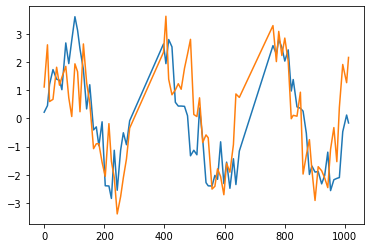

In [37]:
print(sigma_est, tau_est, amplitude_est, nu_est, phi_est)
plt.plot(times_VR, generate_periodic_DRW_LC(times_VR, sigma_est, tau_est, 0, amplitude_est, nu_est, phi_est))
plt.plot(times_VR, generate_periodic_DRW_LC(times_VR, sigma, tau, 0, amplitude, frequency, phi))

print(sigma, sigma_est)
print(tau, tau_est)
print(amplitude, amplitude_est)
print(frequency, nu_est)
print(phi, phi_est)

6152it [04:07, 24.90it/s, +250 | bound: 127 | nc: 1 | ncall: 694121 | eff(%):  0.922 | loglstar:   -inf < -141.269 <    inf | logz: -161.216 +/-  0.370 | dlogz:  0.000 >  0.010]
/Users/adamboesky/opt/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:287: RuntimeWarning: overflow encountered in exp
  for s in range(1, 4)]


<Figure size 432x288 with 0 Axes>

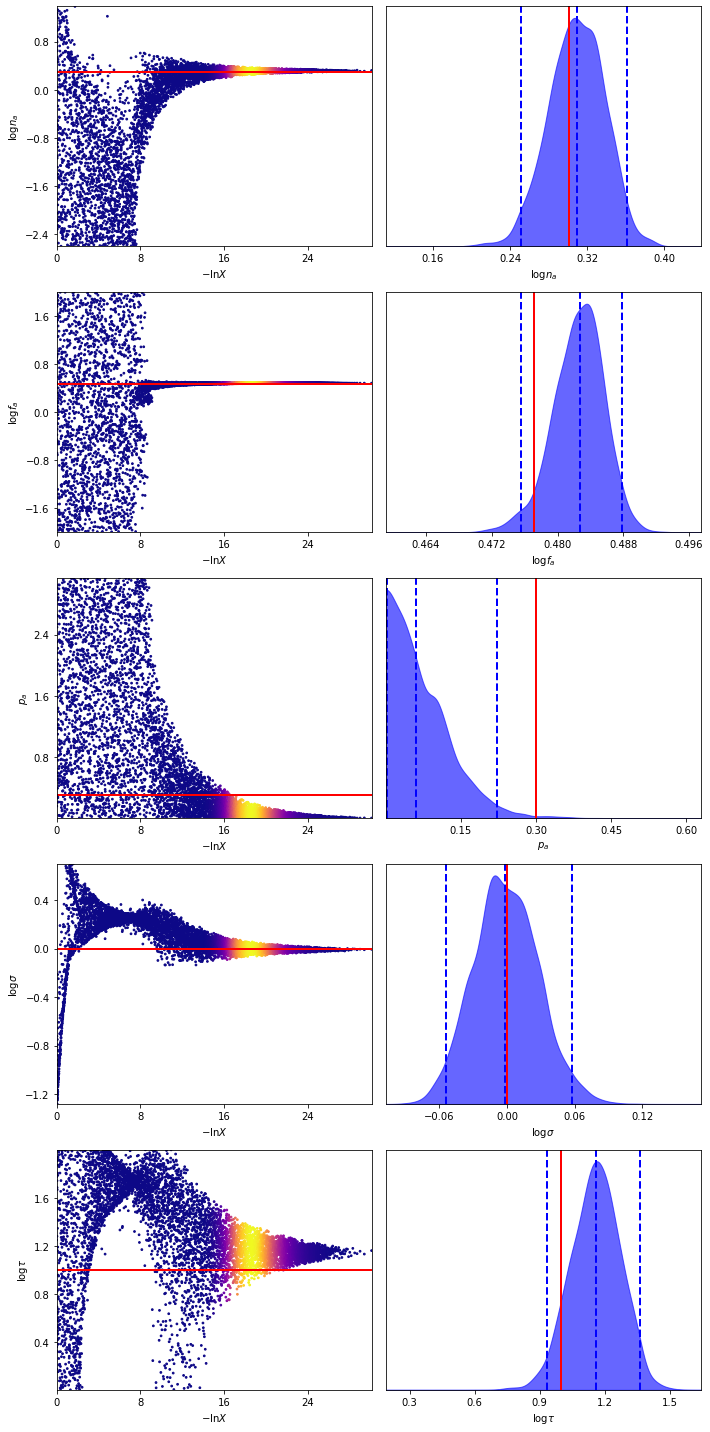

<Figure size 432x288 with 0 Axes>

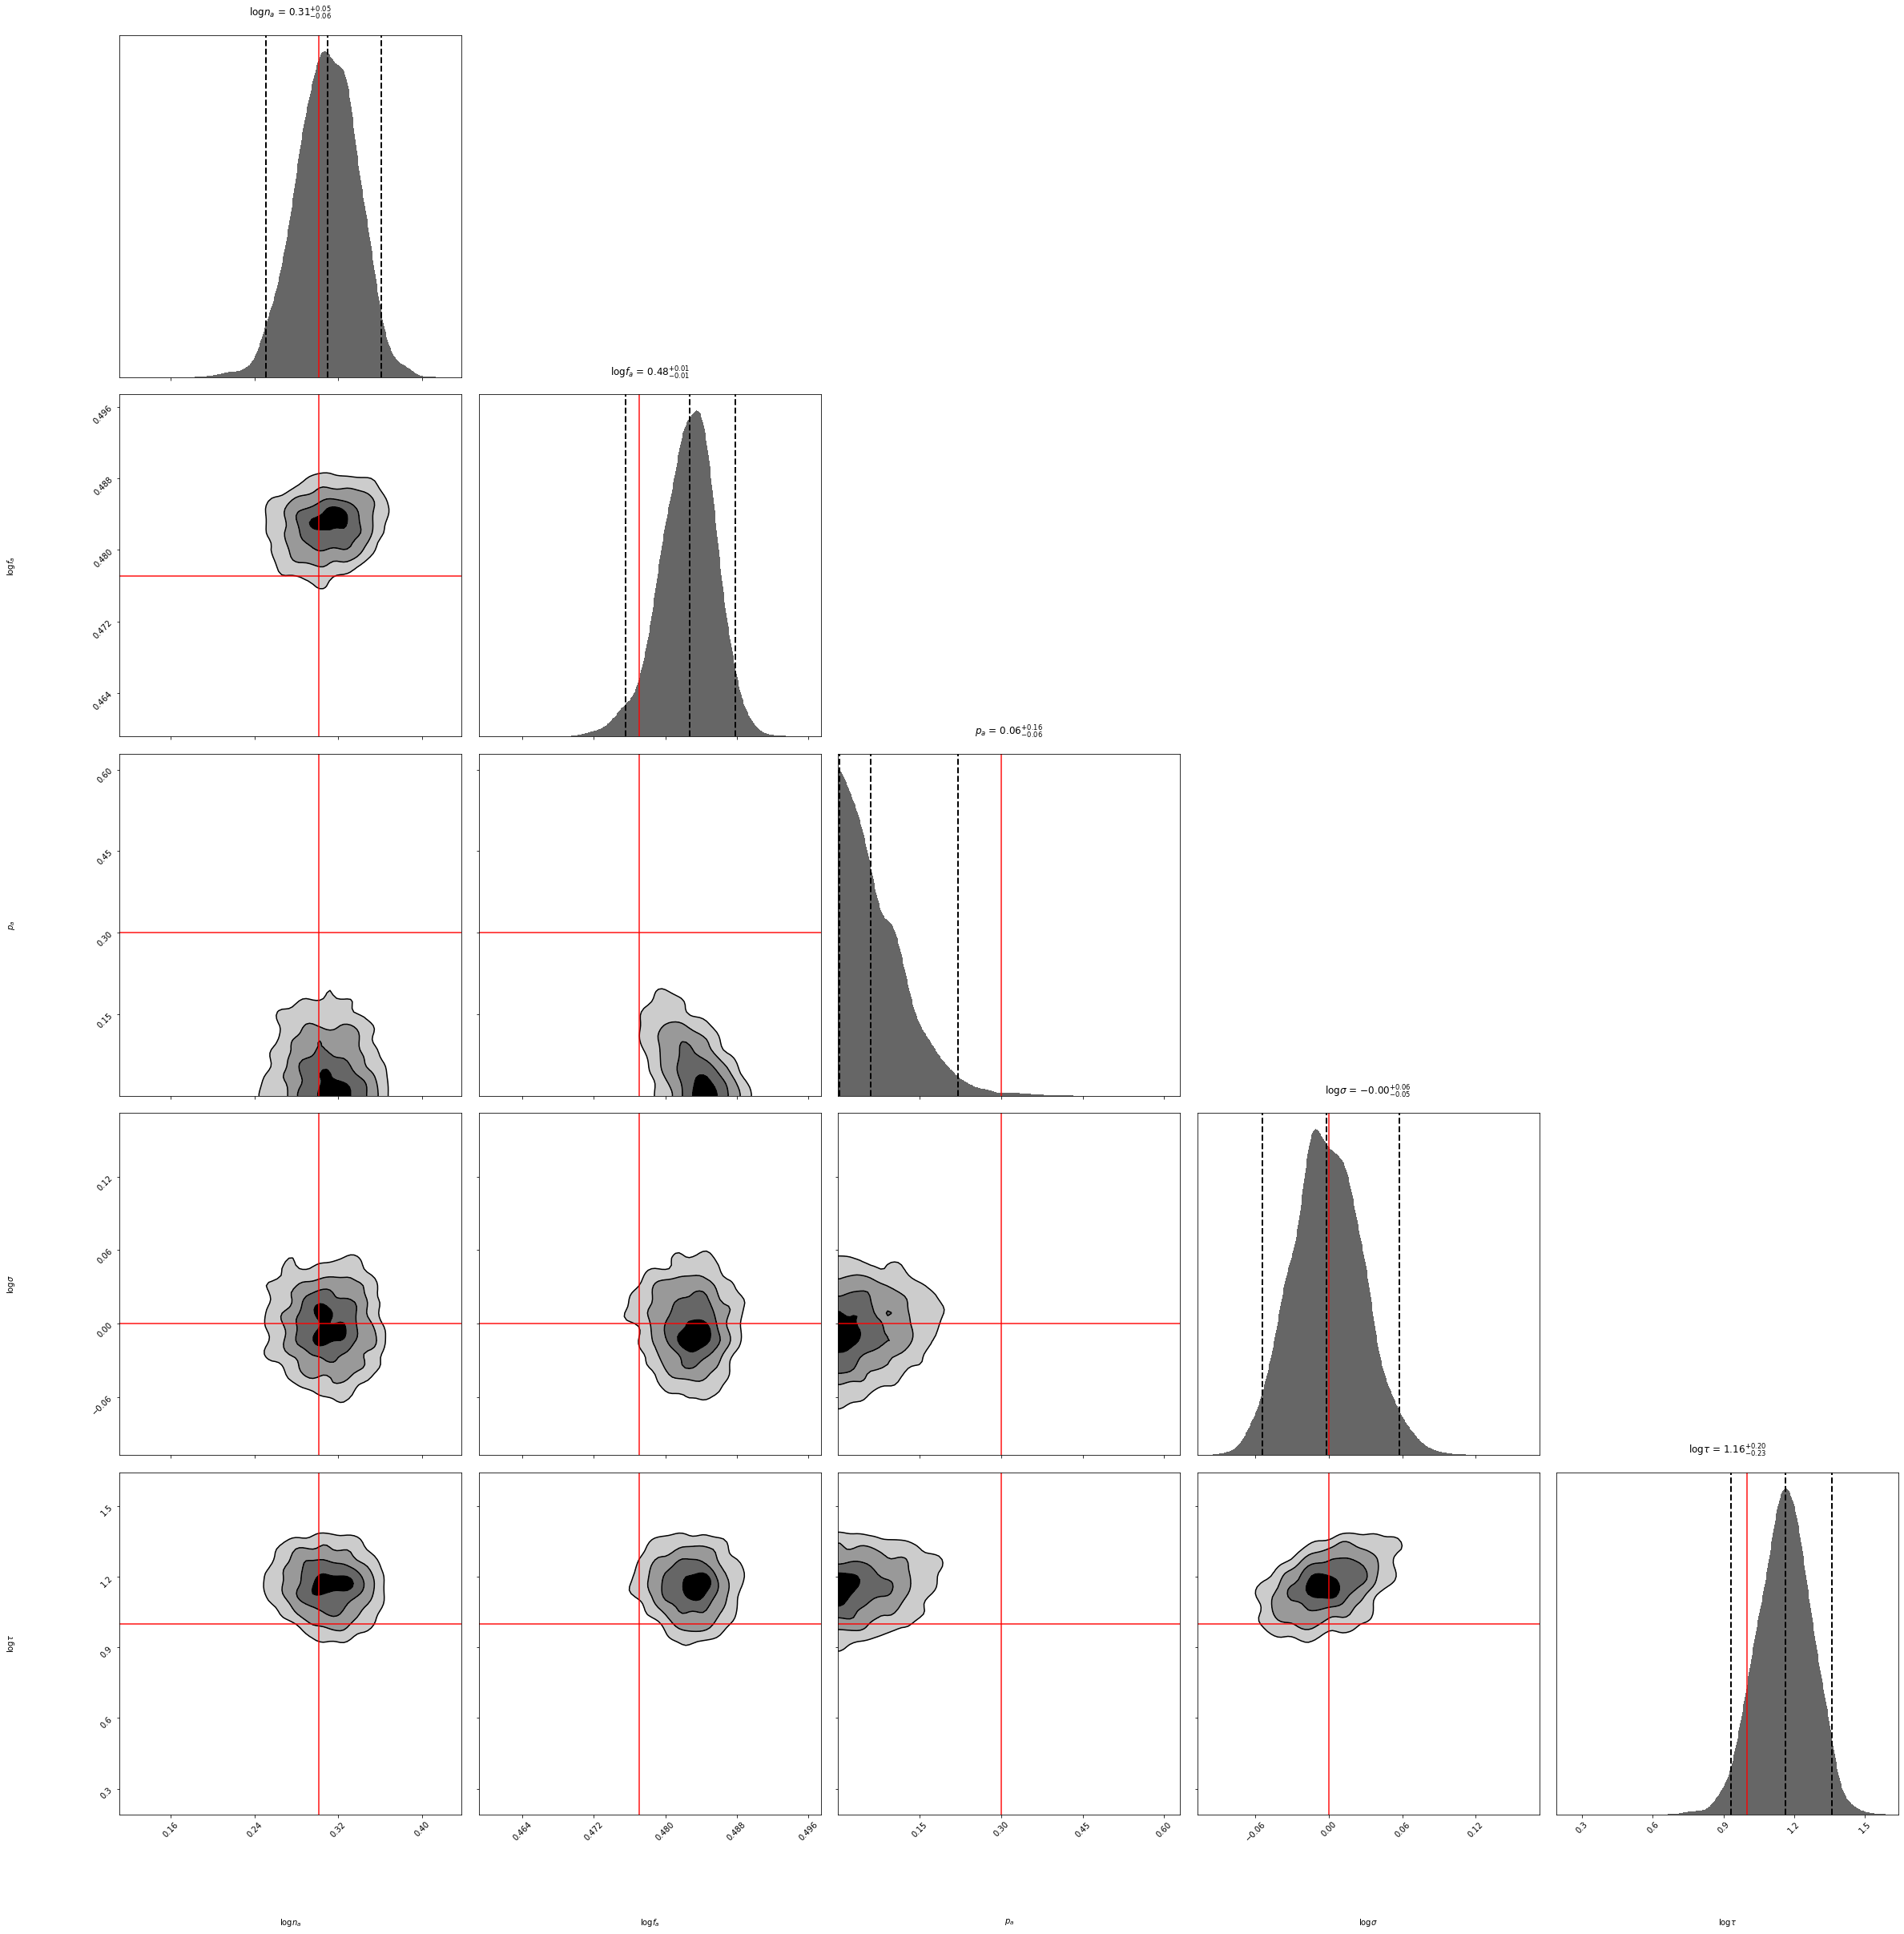

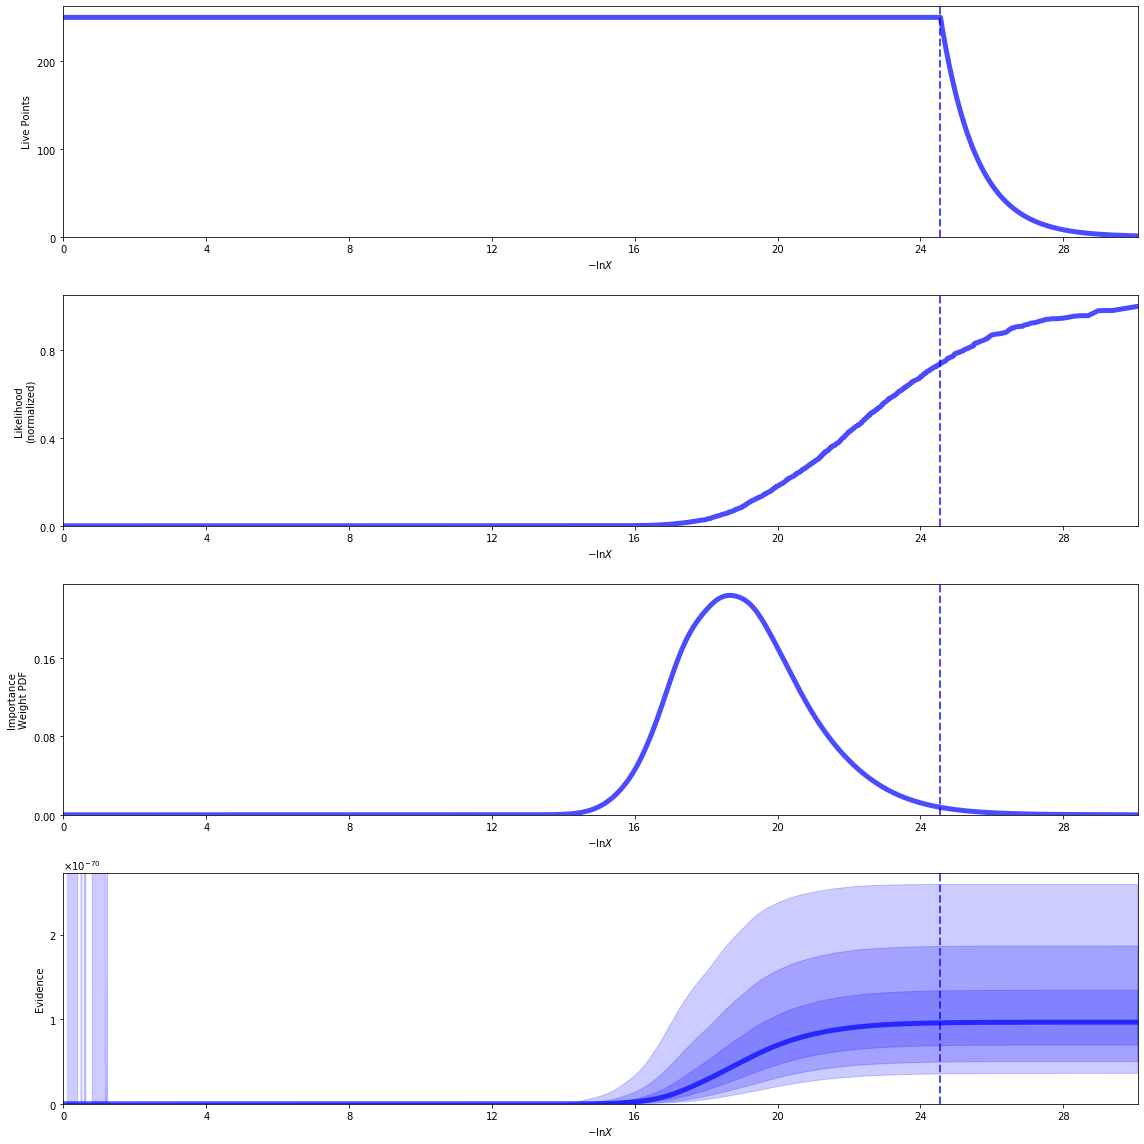

In [38]:
generate_dynesty_graphs(periodic_drw, times_VR, 0, amplitude, frequency, phi, sigma, tau)